In [1]:
import mxnet as mx
from mxnet import init, gluon, test_utils, autograd, nd
from mxnet.gluon import nn, utils
import numpy as np
import gzip, struct
from matplotlib import pyplot as plt
from time import time
%matplotlib inline
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/mnist'

In [2]:
def load_mnist():
    def read_data(label_dir, image_dir):
        with gzip.open(label_dir) as flbl:
            struct.unpack(">II", flbl.read(8))
            label = np.fromstring(flbl.read(), dtype=np.int8)
        with gzip.open(image_dir, 'rb') as fimg:
            _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
            image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
            image = image.reshape(image.shape[0], 1, 28, 28).astype(np.float32)/255
        return label, image
    train_label, train_img = read_data(
        data_dir+'/train-labels-idx1-ubyte.gz', data_dir+'/train-images-idx3-ubyte.gz')
    test_label, test_img = read_data(
        data_dir+'/t10k-labels-idx1-ubyte.gz', data_dir+'/t10k-images-idx3-ubyte.gz')
    return train_img, train_label, test_img, test_label

def visualize(img_arr):
    plt.imshow((img_arr.asnumpy().reshape(28,28)*255).astype(np.uint8), cmap='gray')
    plt.axis('off')

In [3]:
train_img, train_label, test_img, test_label = load_mnist()
train_label = nd.one_hot(nd.array(train_label), 10).astype(np.float32)

batch_size = 64
train_iter = mx.io.NDArrayIter(data=train_img, label=train_label, batch_size=batch_size)
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

In [4]:
netG = nn.HybridSequential()
with netG.name_scope():
    netG.add(nn.Dense(units=128, activation='relu', weight_initializer=init.Xavier()))
    netG.add(nn.Dense(units=784, activation='sigmoid', weight_initializer=init.Xavier()))

netD = nn.HybridSequential()
with netD.name_scope():
    netD.add(nn.Dense(units=128, activation='relu', weight_initializer=init.Xavier()))
    netD.add(nn.Dense(units=1, weight_initializer=init.Xavier()))

In [5]:
netG.initialize(ctx=ctx)
netD.initialize(ctx=ctx)

loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.001})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.001})

In [6]:
epochs = 100

for epoch in range(epochs):
    start = time()
    train_iter.reset()
    for batch in train_iter:
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, 100), ctx=ctx)
        D_input = nd.concat(data.reshape((data.shape[0], -1)), label)
        G_input = nd.concat(latent_z, label)   
        with autograd.record():
            output = netD(D_input)
            errD_real = loss(output, real_label)
            fake = netG(G_input)
            D_fake_input = nd.concat(fake.reshape((fake.shape[0], -1)), label)
            output = netD(D_fake_input.detach())
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
        trainerD.step(data[0].shape[0])
        with autograd.record():
            fake = netG(G_input)
            D_fake_input = nd.concat(fake.reshape((fake.shape[0], -1)), label)
            output = netD(D_fake_input)
            errG = loss(output, real_label)
            errG.backward()
        trainerG.step(data[0].shape[0])

    if epoch%20 == 0:
        print('%d, dloss %.4f, gloss %.4f, T %.4f' %(
            epoch, nd.mean(errD).asscalar(), nd.mean(errG).asscalar(), time()-start))
print('%d, dloss %.4f, gloss %.4f' %(epoch, nd.mean(errD).asscalar(), nd.mean(errG).asscalar())

0, dloss 0.0197, gloss 6.3894, T 3.1772
20, dloss 0.7756, gloss 1.4742, T 3.3712
40, dloss 0.7352, gloss 1.6385, T 3.1249
60, dloss 0.7047, gloss 1.4895, T 3.1290
80, dloss 0.7105, gloss 1.6441, T 3.3069


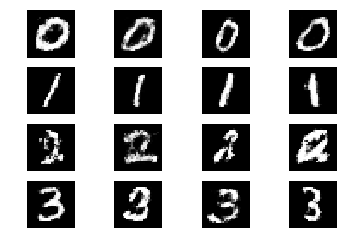

In [7]:
num_image = 4
for digit in range(4):
    for i in range(num_image):
        latent_z = mx.nd.random_normal(0, 1, shape=(1, 100), ctx=ctx)
        label = nd.one_hot(nd.array([[digit]]), 10).as_in_context(ctx)
        img = netG(nd.concat(latent_z, label.reshape((1, 10))))
        plt.subplot(4, 4, digit * 4 + i + 1)
        visualize(img[0])
plt.show()